In [3]:
from kl_validation import NumbaNonequilibriumSimulator, equilibrium_simulator, gamma
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
%matplotlib inline

from w_shad_recorders import vrorv_factory, rvovr_factory, orvro_factory, ovrvo_factory

potential, force, velocity_scale, mass = equilibrium_simulator.potential, equilibrium_simulator.force, equilibrium_simulator.velocity_scale, equilibrium_simulator.mass
schemes = {"VRORV": vrorv_factory(potential, force, velocity_scale, mass),
           "RVOVR": rvovr_factory(potential, force, velocity_scale, mass),
           "ORVRO": orvro_factory(potential, force, velocity_scale, mass),
           "OVRVO": ovrvo_factory(potential, force, velocity_scale, mass),
           }

integrator = partial(schemes["OVRVO"], gamma=gamma, dt=1.0)
noneq_sim = NumbaNonequilibriumSimulator(equilibrium_simulator, integrator)

plt.figure()
plt.hist([noneq_sim.sample_x_from_equilibrium() for _ in range(100000)], bins=50)
plt.savefig("histogram.jpg", dpi=300)
plt.close()


# collect samples from rho
rho = np.zeros((100000, 2))
x = noneq_sim.sample_x_from_equilibrium()
v = noneq_sim.sample_v_given_x(x)
for i in tqdm(range(len(rho))):
    x, v, W = noneq_sim.integrator(x0=x, v0=v, n_steps=10000)
    rho[i] = (x, v)
np.save("rho.npy", rho)

# inner loop of 
def sample_expr_2(n_inner_samples, traj_length):
    # sample x,v from rho
    x,v = rho[np.random.randint(len(rho))]

    mean_exp_work = np.mean(np.exp(- np.array([noneq_sim.accumulate_shadow_work(x, v, traj_length) for _ in range(n_inner_samples)])))
    return np.log(mean_exp_work)


100%|██████████| 100000/100000 [01:34<00:00, 1053.90it/s]


In [4]:
def collect_work_trajectories_from_a_single_rho_sample(n_inner_samples, traj_length):
    # sample x,v from rho
    x,v = rho[np.random.randint(len(rho))]
    return np.array([noneq_sim.accumulate_shadow_work(x, v, traj_length) for _ in range(n_inner_samples)])

In [5]:
W = collect_work_trajectories_from_a_single_rho_sample(10000, 1000)

In [6]:
Ws = np.array([collect_work_trajectories_from_a_single_rho_sample(1000, 100) for _ in tqdm(range(500))])

100%|██████████| 500/500 [00:06<00:00, 82.82it/s]


In [7]:
Ws.shape

(500, 1000, 100)

In [96]:
Ws.std(2)

array([[ 0.21567179,  3.57328315,  0.43999042, ...,  1.02774299,
         0.3826882 ,  0.53817485],
       [ 0.88542555,  0.31302056,  0.91506045, ...,  0.32202459,
         0.1948688 ,  0.58044118],
       [ 0.18016225,  0.98241168,  0.3018209 , ...,  0.52558307,
         1.19554713,  0.711828  ],
       ..., 
       [ 1.29887283,  1.76870681,  0.77444271, ...,  0.4616571 ,
         1.19978317,  1.35327729],
       [ 2.51403893,  0.51954277,  0.36652327, ...,  0.1560269 ,
         0.28349408,  0.64274996],
       [ 0.78637902,  0.28813459,  0.39682714, ...,  0.27435425,
         0.37425155,  0.54949011]])

In [8]:
# expression 2 estimates
estimates = np.mean(np.log(np.mean(np.exp(-Ws), 0)), 0)
estimates

array([ 0.        ,  0.01017045,  0.01074201,  0.01089468,  0.01198967,
        0.01184398,  0.0116667 ,  0.01198567,  0.01140483,  0.01128018,
        0.01159608,  0.01140734,  0.01187162,  0.01211543,  0.01169478,
        0.01134872,  0.0112254 ,  0.01151125,  0.01155305,  0.01128964,
        0.01074973,  0.01045812,  0.01017791,  0.01092177,  0.01022592,
        0.00988703,  0.00980153,  0.00858742,  0.00930248,  0.00886018,
        0.00826849,  0.0081227 ,  0.00649041,  0.00792691,  0.00809005,
        0.00776769,  0.0076761 ,  0.00703209,  0.00654357,  0.00648869,
        0.0066261 ,  0.00602339,  0.0052257 ,  0.0045944 ,  0.0044312 ,
        0.00414048,  0.00466774,  0.00453371,  0.00440904,  0.00411731,
        0.00450296,  0.00449515,  0.0027    ,  0.0038412 ,  0.00279022,
        0.00268492,  0.00370352,  0.0036024 ,  0.00387468,  0.00290001,
        0.00231931,  0.00334469,  0.00197981,  0.00208109,  0.00122618,
        0.00093187,  0.00070983,  0.00077651,  0.00041763, -0.00

In [9]:
mean_Ws = np.mean(Ws, 1)
mean_Ws.shape

(500, 100)

In [10]:
DeltaWs = np.array([(Ws[:,i,:] - mean_Ws) for i in range(Ws.shape[1])])

In [11]:
np.exp(-DeltaWs).mean(0).shape

(500, 100)

In [12]:
plt.plot(np.mean(np.log(np.exp(-DeltaWs).mean(0)), 0))

In [13]:
# what's the average steady state work?
traj_length = 100
n_samples = 10000
mean_steady_state_work = np.zeros(traj_length)
for _ in tqdm(range(n_samples)):
    x, v = rho[np.random.randint(len(rho))]
    mean_steady_state_work += noneq_sim.accumulate_shadow_work(x, v, traj_length)
mean_steady_state_work /= n_samples

100%|██████████| 10000/10000 [00:00<00:00, 47888.16it/s]


In [14]:
noneq_sim.accumulate_shadow_work(x, v, traj_length).shape

(100,)

In [15]:
term_1 = (np.mean(np.log(np.exp(-DeltaWs).mean(0)), 0))
term_2 = mean_steady_state_work

In [19]:
%matplotlib inline

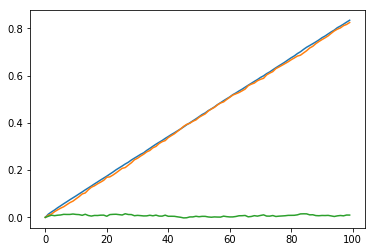

In [20]:
plt.plot(term_1)
plt.plot(term_2)
plt.plot(term_1 - term_2)

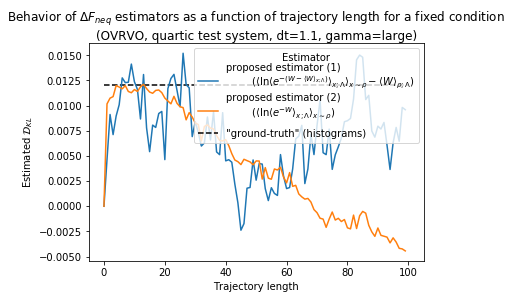

In [21]:
plt.plot(term_1 - term_2, label='proposed estimator (1)\n\t' + r"($\langle \ln \langle e^{-(W - \langle W \rangle_{x; \Lambda})} \rangle_{x; \Lambda} \rangle_{x \sim \rho} - \langle W \rangle_{\rho; \Lambda}$)")
plt.plot(estimates, label='proposed estimator (2)\n\t' + r"($\langle \ln \langle e^{-W} \rangle_{x; \Lambda} \rangle_{x \sim \rho}$)")
plt.hlines(0.012, 0, len(term_1), linestyles='--', label='"ground-truth" (histograms)')
plt.legend(loc='best', title="Estimator")
plt.xlabel("Trajectory length")
plt.ylabel(r"Estimated $\mathcal{D}_{KL}$")
plt.title(r"Behavior of $\Delta F_{neq}$ estimators as a function of trajectory length for a fixed condition" + "\n(OVRVO, quartic test system, dt=1.1, gamma=large)")

plt.savefig('estimator_behavior.jpg', dpi=300, bbox_inches='tight')

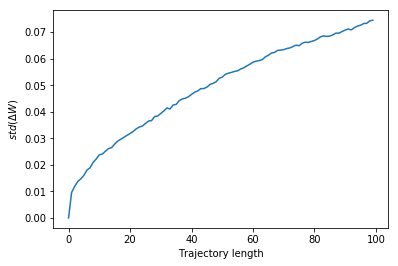

In [24]:
plt.plot(np.std(np.mean(DeltaWs, 1), 0))
plt.ylabel(r"$std(\Delta W)$")
plt.xlabel("Trajectory length")

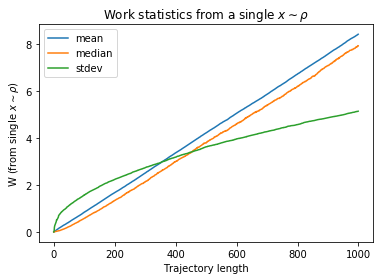

In [25]:
plt.plot(W.mean(0), label='mean')
plt.plot(np.median(W, 0), label='median')
plt.plot(W.std(0), label='stdev')
plt.legend()

plt.ylabel(r"W (from single $x \sim \rho$)")
plt.xlabel("Trajectory length")
plt.title(r"Work statistics from a single $x \sim \rho$")
plt.savefig("example_work_statistics.jpg", dpi=300)

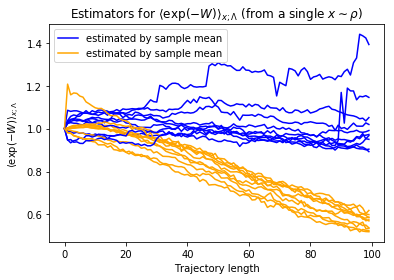

In [33]:
for i in range(10):
    if i == 0:
        labels = ["estimated by sample mean", "estimated by sample median"]
    else:
        labels = [None, None]
    plt.plot(np.mean(np.exp(-Ws[i]),0), label=labels[0], color="blue")
    plt.plot(np.median(np.exp(-Ws[i]),0), label=labels[0], color="orange")
plt.ylabel(r"$\langle \exp(-W) \rangle_{x; \Lambda}$")
plt.xlabel("Trajectory length")
plt.title(r"Estimators for $\langle \exp(-W) \rangle_{x; \Lambda}$ (from a single $x \sim \rho$)")
plt.legend()
plt.savefig("exp_avg_noneq_work_starting_from_single_x_from_rho.jpg", dpi=300)